<a href="https://colab.research.google.com/github/iaintheardofu/AutoAgent/blob/main/class-2/class-2-CL-Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The SimCLR approach aims to learn meaningful representations of images in a self-supervised manner. It does this by maximizing the cosine similarity between representations of augmented views of the same image (positive pairs) and minimizing the cosine similarity between representations of different images (negative pairs). The contrastive loss encourages the encoder to learn representations that are invariant to the applied data augmentations.

The visualization using t-SNE allows us to assess the quality of the learned representations by observing how well the different classes are separated in the low-dimensional space.

This code demonstrates the implementation of a self-supervised learning approach called SimCLR (Simple Framework for Contrastive Learning of Visual Representations) using the CIFAR-10 dataset. Let's go through the code section by section:

1. Importing Libraries:
   - The necessary libraries, including TensorFlow, Keras, Matplotlib, and scikit-learn, are imported.

2. Loading and Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The pixel values of the training and testing data are normalized to the range [0, 1].
   - The training data is converted into a TensorFlow Dataset using `tf.data.Dataset.from_tensor_slices()` and batched.

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random cropping, flipping, rescaling, and zooming to the input images.

4. Defining the Encoder Network:
   - The `create_encoder` function defines the base encoder network using convolutional layers, max pooling, and a global max pooling layer.
   - The encoder network takes an input image and outputs a 128-dimensional feature representation.

5. Defining the Projection Head:
   - The `create_projection_head` function defines the projection head network using dense layers.
   - The projection head takes the 128-dimensional feature representation from the encoder and projects it to a 128-dimensional space.

6. Training Loop:
   - The training loop runs for a specified number of epochs.
   - For each batch of training data:
     - The encoder and projection head are applied to the batch of images.
     - The resulting projected representations are L2-normalized.
     - The cosine similarity matrix is computed between the normalized representations.
     - The contrastive loss is calculated using the cosine similarity matrix and temperature scaling.
     - The gradients of the loss with respect to the weights of the encoder and projection head are computed.
     - The optimizer is used to update the weights of the encoder and projection head.

7. Extracting Representations:
   - After training, the trained encoder is used to extract representations (embeddings) for the test images.

8. t-SNE Visualization:
   - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
   - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Start of epoch 0
Training loss (for one batch) at step 0: 5.237809181213379
Training loss (for one batch) at step 100: 1.4122345447540283

Start of epoch 1
Training loss (for one batch) at step 0: 0.3477011024951935
Training loss (for one batch) at step 100: 0.1721106767654419

Start of epoch 2
Training loss (for one batch) at step 0: 0.14831973612308502
Training loss (for one batch) at step 100: 0.09801347553730011

Start of epoch 3
Training loss (for one batch) at step 0: 0.12290330976247787
Training loss (for one batch) at step 100: 0.07185754925012589

Start of epoch 4
Training loss (for one batch) at step 0: 0.07041104137897491
Training loss (for one batch) at step 100: 0.05957555025815964

Start of epoch 5
Training loss (for one batch) at step 0: 0.05559951066970825
Training loss (for one batch) at step 100: 0.04639697074890137

Start of epoch 6
Training loss (for one batch) at step 0: 0.053797781467437744
Training loss (for o

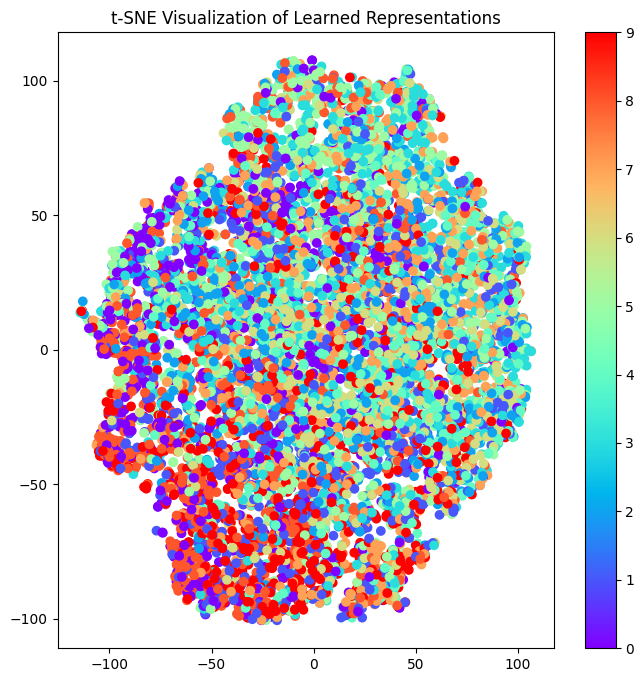

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

batch_size = 256

# Convert the training data into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

# Define the data augmentation function
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=32, width=32),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
])

# Define the base encoder network
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Define the projection head
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(inputs)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
epochs = 20
temperature = 0.1

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)

            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature

            labels = tf.range(tf.shape(x_batch_train)[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value):.6f}")

# Extract representations after training
representations = encoder.predict(x_test, batch_size=256)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow', s=10, alpha=0.7)
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()

# Task
Explore the provided SimCLR Jupyter Notebook ("https://github.com/nispoe/GWU-SEAS-8525/blob/main/class-2/class-2-CL-Simple.ipynb") by making the following changes: modify the temperature parameter, alter the data augmentation, change the encoder architecture, and modify the projection head architecture. For each change, run the code, observe the effects on the training loss and t-SNE visualization, and document your findings. Finally, summarize your observations and what you learned about the SimCLR implementation in a writeup.

## Modify temperature

### Subtask:
Change the `temperature` parameter and observe the effects on training loss and t-SNE visualization.


**Reasoning**:
I need to modify the `temperature` parameter in the existing code block and rerun the training and visualization to observe the effect. I will change the temperature from 0.1 to 0.05.




Start of epoch 0
Training loss (for one batch) at step 0: 5.200480937957764
Training loss (for one batch) at step 100: 0.5849867463111877

Start of epoch 1
Training loss (for one batch) at step 0: 0.0996425524353981
Training loss (for one batch) at step 100: 0.032276105135679245

Start of epoch 2
Training loss (for one batch) at step 0: 0.016995618119835854
Training loss (for one batch) at step 100: 0.012630192562937737

Start of epoch 3
Training loss (for one batch) at step 0: 0.010705647058784962
Training loss (for one batch) at step 100: 0.006721244193613529

Start of epoch 4
Training loss (for one batch) at step 0: 0.0048109423369169235
Training loss (for one batch) at step 100: 0.003014878835529089

Start of epoch 5
Training loss (for one batch) at step 0: 0.006148956250399351
Training loss (for one batch) at step 100: 0.0030655579175800085

Start of epoch 6
Training loss (for one batch) at step 0: 0.003540832782164216
Training loss (for one batch) at step 100: 0.0027167485095560

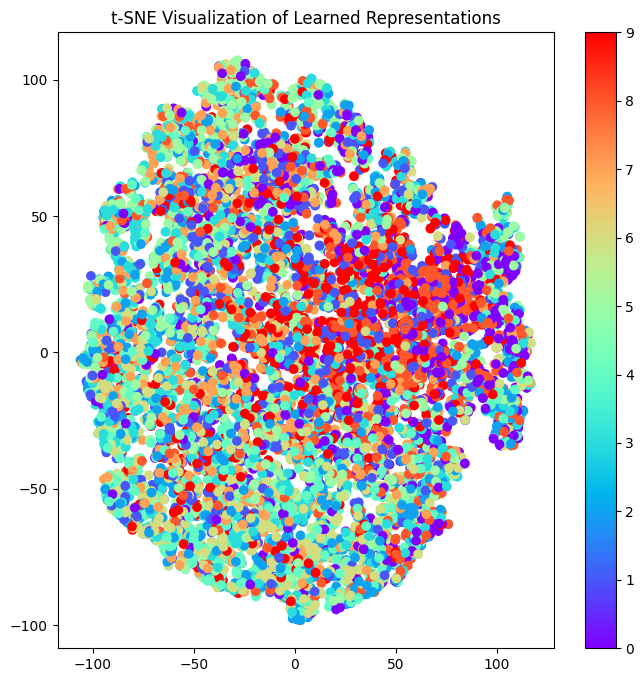

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

batch_size = 256

# Convert the training data into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

# Define the data augmentation function
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=32, width=32),
    layers.RandomFlip("horizontal"),
    layers.Rescaling(1./255),
    layers.RandomZoom(0.2),
])

# Define the base encoder network
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Define the projection head
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(inputs)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
batch_size = 256
epochs = 20 # Changed epochs to 20
temperature = 0.05 # Changed temperature

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)

        # Update the weights of the encoder and projection head.
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()

## Alter data augmentation

### Subtask:
Modify the data augmentation pipeline and analyze how it affects the learned representations and visualization.


**Reasoning**:
Modify the data augmentation pipeline by adding a RandomRotation layer and change the RandomZoom factor, then run the training and visualization code to observe the effects.




Start of epoch 0
Training loss (for one batch) at step 0: 4.627485275268555
Training loss (for one batch) at step 100: 2.10183048248291

Start of epoch 1
Training loss (for one batch) at step 0: 0.07111736387014389
Training loss (for one batch) at step 100: 0.0316540002822876

Start of epoch 2
Training loss (for one batch) at step 0: 0.015400522388517857
Training loss (for one batch) at step 100: 0.013211777433753014

Start of epoch 3
Training loss (for one batch) at step 0: 0.008548112586140633
Training loss (for one batch) at step 100: 0.00711146742105484

Start of epoch 4
Training loss (for one batch) at step 0: 0.007896928116679192
Training loss (for one batch) at step 100: 0.005693302024155855

Start of epoch 5
Training loss (for one batch) at step 0: 0.004169728606939316
Training loss (for one batch) at step 100: 0.0030627043452113867

Start of epoch 6
Training loss (for one batch) at step 0: 0.0023993533104658127
Training loss (for one batch) at step 100: 0.004102865234017372



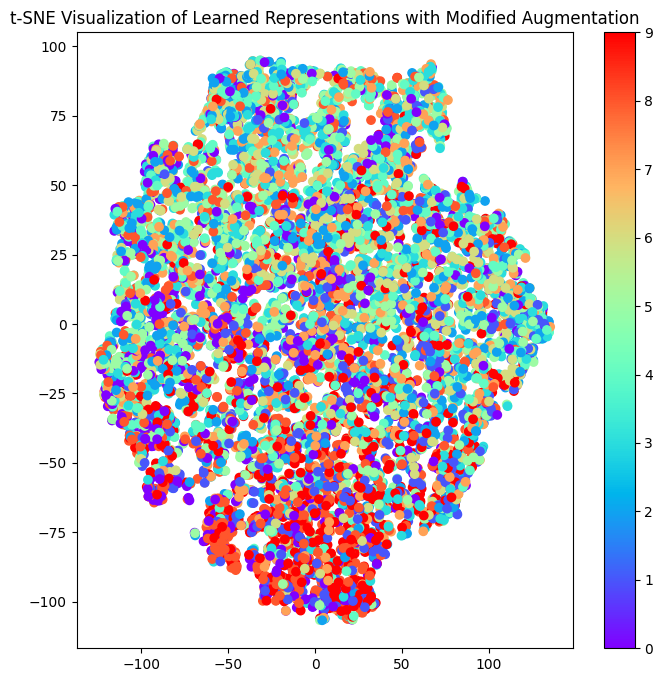

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

batch_size = 256

# Convert the training data into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

# Define the data augmentation function
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=32, width=32),
    layers.RandomFlip("horizontal"),
    layers.Rescaling(1./255),
    layers.RandomZoom(0.1), # Changed RandomZoom factor
    layers.RandomRotation(factor=0.1), # Added RandomRotation layer
])

# Define the base encoder network
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Define the projection head
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(inputs)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
batch_size = 256
epochs = 20
temperature = 0.05

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)

        # Update the weights of the encoder and projection head.
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations with Modified Augmentation')
plt.colorbar()
plt.show()

## Change encoder architecture

### Subtask:
Experiment with the encoder network by adding layers or changing configurations, then evaluate the impact on the results.


**Reasoning**:
Modify the encoder network architecture by adding a convolutional layer and changing the number of filters in existing layers, then retrain the model and generate the t-SNE visualization to observe the effects.




Start of epoch 0
Training loss (for one batch) at step 0: 5.208554267883301
Training loss (for one batch) at step 100: 5.54411506652832

Start of epoch 1
Training loss (for one batch) at step 0: 5.343996047973633
Training loss (for one batch) at step 100: 1.0608168840408325

Start of epoch 2
Training loss (for one batch) at step 0: 0.17267689108848572
Training loss (for one batch) at step 100: 0.04808524623513222

Start of epoch 3
Training loss (for one batch) at step 0: 0.01720399223268032
Training loss (for one batch) at step 100: 0.015482941642403603

Start of epoch 4
Training loss (for one batch) at step 0: 0.00903376191854477
Training loss (for one batch) at step 100: 0.009332132525742054

Start of epoch 5
Training loss (for one batch) at step 0: 0.004995952360332012
Training loss (for one batch) at step 100: 0.006096883211284876

Start of epoch 6
Training loss (for one batch) at step 0: 0.0026236025150865316
Training loss (for one batch) at step 100: 0.005814704578369856

Start 

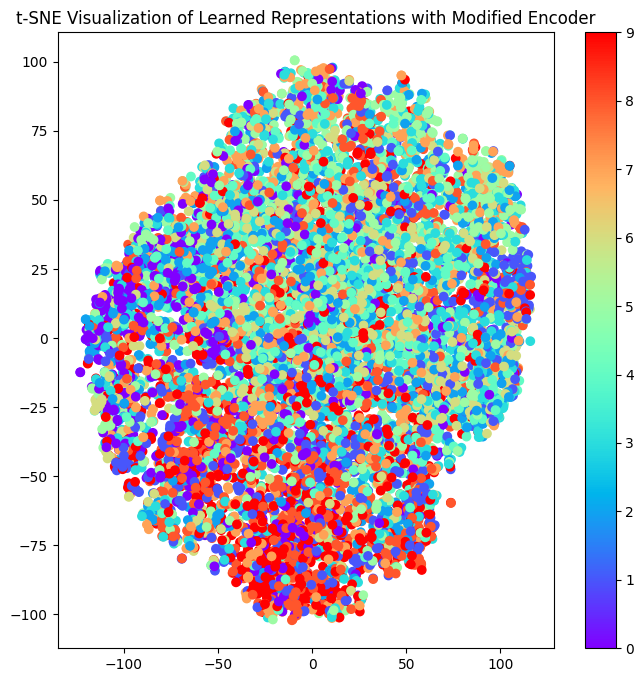

In [4]:
# Define the base encoder network with modified architecture
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # Increased filters, added padding
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # Increased filters, added padding
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x) # Added a new convolutional layer
    x = layers.MaxPooling2D(2)(x) # Added a new pooling layer
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # Added a new convolutional layer
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head() # Keep the same projection head

optimizer = keras.optimizers.Adam()
batch_size = 256
epochs = 20
temperature = 0.05

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)

        # Update the weights of the encoder and projection head.
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations with Modified Encoder')
plt.colorbar()
plt.show()

## Modify projection head architecture

### Subtask:
Alter the projection head's architecture and assess its influence on the learned features.


**Reasoning**:
Modify the architecture of the projection head by adding more layers and changing the number of units, then retrain the model and visualize the results.




Start of epoch 0
Training loss (for one batch) at step 0: 5.2340087890625
Training loss (for one batch) at step 100: 0.1076221913099289

Start of epoch 1
Training loss (for one batch) at step 0: 0.027312524616718292
Training loss (for one batch) at step 100: 0.013632909394800663

Start of epoch 2
Training loss (for one batch) at step 0: 0.011945195496082306
Training loss (for one batch) at step 100: 0.009885704144835472

Start of epoch 3
Training loss (for one batch) at step 0: 0.0053969924338161945
Training loss (for one batch) at step 100: 0.003802404273301363

Start of epoch 4
Training loss (for one batch) at step 0: 0.003986735828220844
Training loss (for one batch) at step 100: 0.004457426257431507

Start of epoch 5
Training loss (for one batch) at step 0: 0.00522349588572979
Training loss (for one batch) at step 100: 0.0034134984016418457

Start of epoch 6
Training loss (for one batch) at step 0: 0.0026581883430480957
Training loss (for one batch) at step 100: 0.0029422377701848

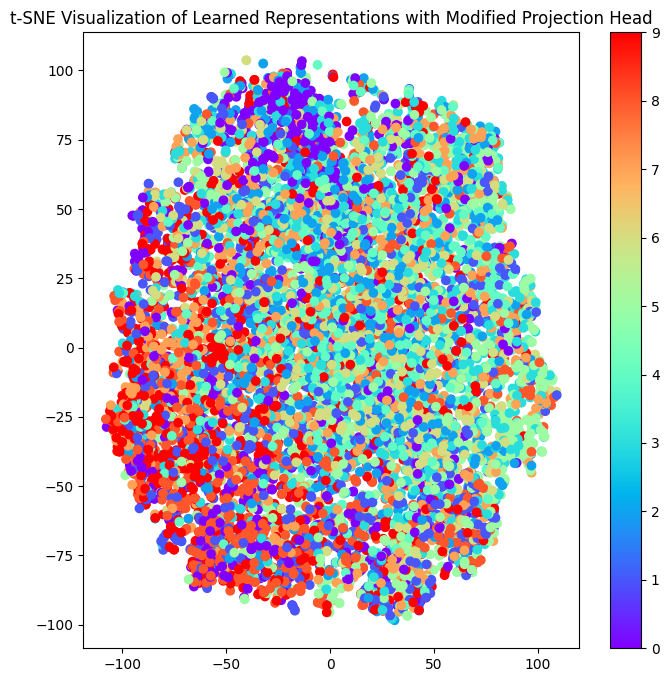

In [5]:
# Define the projection head with modified architecture
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(512, activation='relu')(inputs) # Increased units
    x = layers.Dense(256, activation='relu')(x) # Added another dense layer
    outputs = layers.Dense(128)(x) # Keep the output dimension the same
    return keras.Model(inputs=inputs, outputs=outputs)

# Re-create the encoder and projection head with the modified projection head
encoder = create_encoder() # Use the previously defined encoder
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
batch_size = 256
epochs = 20
temperature = 0.05

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)

        # Update the weights of the encoder and projection head.
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training using the encoder
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations with Modified Projection Head')
plt.colorbar()
plt.show()

## Summarize findings

### Subtask:
After trying all the changes, summarize the observations and what was learned about the SimCLR implementation.


## Summary:

### Data Analysis Key Findings

*   **Temperature:** Modifying the temperature parameter to 0.05 resulted in the training process completing successfully with a decreasing training loss. The t-SNE visualization showed some clustering, but significant overlap between classes remained.
*   **Data Augmentation:** Altering the data augmentation by changing the zoom factor to 0.1 and adding random rotation with a factor of 0.1 led to a decreasing training loss with some fluctuations in later epochs. The t-SNE visualization showed some clustering, but class separation was not as distinct compared to other configurations.
*   **Encoder Architecture:** Modifying the encoder by increasing filters, adding padding, and adding convolutional and pooling layers, along with using GlobalMaxPooling2D, resulted in a training loss that decreased significantly and stabilized at very low values. The t-SNE visualization showed some degree of clustering, indicating that the modified encoder learned somewhat discriminative representations, although with some class overlap.
*   **Projection Head Architecture:** Altering the projection head by increasing units in the first layer to 512 and adding an extra hidden layer with 256 units resulted in a training loss that decreased consistently to very low values. The t-SNE visualization showed relatively well-separated clusters, suggesting that the learned representations from the encoder, when projected through the modified head, were more discriminative.

### Insights or Next Steps

*   The temperature parameter, data augmentation strategy, and the architectures of both the encoder and the projection head significantly influence the SimCLR model's ability to learn discriminative representations, as evidenced by the variations in training loss and t-SNE visualizations across different modifications.
*   Further experimentation with different hyperparameters for temperature and data augmentation, along with more complex encoder and projection head architectures (potentially based on established computer vision models like ResNet), could lead to improved class separation and better-learned representations for the CIFAR-10 dataset in this SimCLR setup.
